In [7]:
from google.cloud import bigquery
import pandas as pd
import ast
import glove_helper
import tensorflow as tf
import numpy as np
import scipy
import keras
from itertools import groupby
from os.path import basename, splitext
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import regex as re

In [2]:
client = bigquery.Client(project='manifest-frame-203601')

/Users/cathyzhou/anaconda3/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
QUERY = (
    """
    select * from w266_final.final_20k
    LIMIT 1000""")
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish

df = []
for row in rows:
    df.append([row.repo_path,row.c_content])

In [4]:
df = pd.DataFrame(df)
df.columns = ['repo_path','content']
df.shape


(1000, 2)

In [60]:
content = []
for i in df['content']:
    content.append(tf.compat.as_str(i).split())
content = [item for sublist in content for item in sublist]
regex = re.compile('[^a-zA-Z]')
content_new = []
for i in content:
    i_1 = regex.sub('', i)
    content_new.append(i_1)
content_new = list(filter(None, content_new))
content_new[:10]

['from',
 'abc',
 'import',
 'abstractmethod',
 'ABCMeta',
 'class',
 'BaseRecordTypeobject',
 'metaclass',
 'ABCMeta',
 'abstractmethod']

In [61]:
import urllib.request
import collections
import math
import os
import random

def build_dataset(words, n_words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [63]:
## create dataset, distionary 
data, count, dictionary, reversed_dictionary = build_dataset(content_new,10000)
count = sorted(count, key=lambda tup: tup[1],reverse=True) ## sort the count list descending
count[:5]

[['UNK', 70070], ('the', 7347), ('def', 6187), ('if', 5257), ('import', 4809)]

In [86]:
from gensim.models import Word2Vec

sentences=[]
for i in df['content']:
    i_1 = regex.sub(' ',i)
    sentences.append(i_1)
sentences_new = [item for sublist in sentences for item in sublist]
sentences_new = [i.split() for i in sentences]
sentences_new[:1]
### use word2vec model under gensim, set minimum count to 1, and use skip gram as the training method
model = Word2Vec(sentences_new, min_count=1,sg=1)

In [91]:
words = list(model.wv.vocab)
words[1]

'abc'

/Users/cathyzhou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


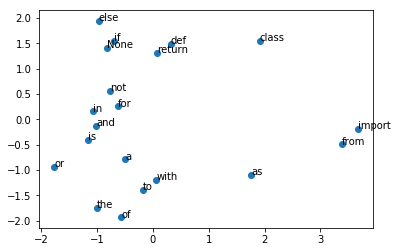

In [92]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

top10 = [i[0] for i in count[1:21]]
top10
X = model[top10]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(top10):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [93]:
result  = model.most_similar(positive=['calculate','distance'], topn=2)
print(result)

[('similarities', 0.9288420677185059), ('minibatch', 0.9274359345436096)]


/Users/cathyzhou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/cathyzhou/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
